# Event-related Analysis


In [37]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [38]:
# This "decorative" cell should be hidden from the docs once this is implemented:
# https://github.com/microsoft/vscode-jupyter/issues/1182 
plt.rcParams['figure.figsize'] = [15, 5]  # Bigger images
plt.rcParams['font.size']= 14


This example shows how to use NeuroKit to extract epochs from data based on events localisation and its corresponding physiological signals. That way, you can compare experimental conditions with one another.

link: https://neuropsychology.github.io/NeuroKit/examples/bio_eventrelated/bio_eventrelated.html

## The Dataset

Use the nk.data() function to load the dataset located on NeuroKit data folder.

It contains 2.5 minutes of biosignals recorded at a frequency of 100Hz (2.5 x 60 x 100 = 15000 data points).

Biosignals : ECG, RSP, EDA + Photosensor (event signal)



In [39]:
# Download data
data = nk.data("bio_eventrelated_100hz")

This is the data from one participant that saw 4 emotional and neutral images from the IAPS), which we will refer to as events.

Importantly, the images were marked in the recording system (the “triggers”) by a small black rectangle on the screen, which led to the photosensor signal to go down (and then up again after the image). This is what will allow us to retrieve the location of these events.

They were 2 types of images (the condition) that were shown to the participant: “Negative” vs. “Neutral” (in terms of emotion). Each picture was presented for 3 seconds. The following list is the condition order.

In [40]:
condition_list = ["Negative", "Neutral", "Neutral", "Negative"]


# Find Events
These events can be localized and extracted using events_find().

Note that you should also specify whether to select events that are higher or below the threshold using the threshold_keep argument.

In [41]:
# Find events
events = nk.events_find(data["Photosensor"], threshold_keep='below', event_conditions=condition_list)
events

{'onset': array([ 1024,  4957,  9224, 12984]),
 'duration': array([300, 300, 300, 300]),
 'label': array(['1', '2', '3', '4'], dtype='<U11'),
 'condition': ['Negative', 'Neutral', 'Neutral', 'Negative']}

As we can see, events_find() returns a dict containing onsets and durations for each corresponding event, based on the label for event identifiers and each event condition. Each event here lasts for 300 data points (equivalent to 3 seconds sampled at 100Hz).

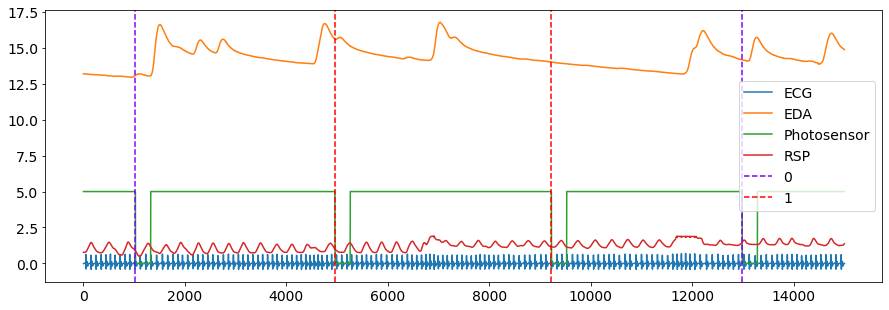

In [42]:
# Plot the location of event with the signals
plot = nk.events_plot(events, data)

The output of events_plot() shows the corresponding events in the signal, with the blue dashed line representing a Negative event and red dashed line representing a Neutral event.

# Process the Signals
Now that we have the events location, we can go ahead and process the data.

Biosignals processing can be done quite easily using NeuroKit with the bio_process() function. Simply provide the appropriate biosignal channels and additional channels that you want to keep (for example, the photosensor), and bio_process() will take care of the rest. It will return a dataframe containing processed signals and a dictionary containing useful information.

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

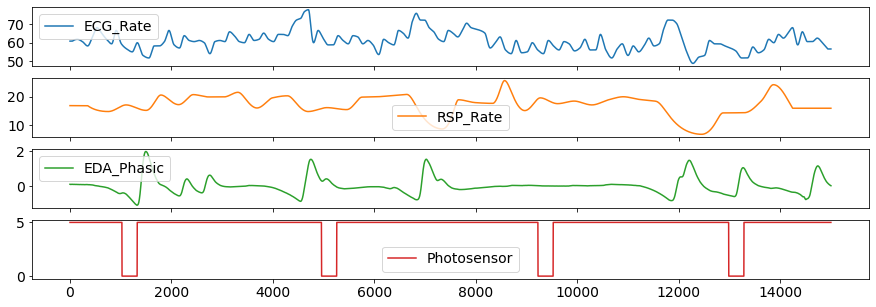

In [43]:
# Process the signal
data_clean, info = nk.bio_process(ecg=data["ECG"], 
                                  rsp=data["RSP"], 
                                  eda=data["EDA"], 
                                  keep=data["Photosensor"], 
                                  sampling_rate=100)

# Visualize some of the channels
data_clean[["ECG_Rate", "RSP_Rate", "EDA_Phasic", "Photosensor"]].plot(subplots=True)

# Create Epochs
We now have to transform this dataframe into epochs, i.e. segments (chunks) of data around the events using epochs_create(). We want it to start 1 second before the event onset and end 6 seconds after. These values are passed into the epochs_start and epochs_end arguments, respectively.

Our epochs will then cover the region from -1 s to +6 s (i.e., 700 data points since the signal is sampled at 100Hz).

In [44]:
# Build and plot epochs
epochs = nk.epochs_create(data_clean, events, sampling_rate=100, epochs_start=-1, epochs_end=6)

C:\Users\Azzy\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:5239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


Let’s plot some of the signals of the first epoch (and transform them to the same scale for visualization purposes).

In [50]:
# Iterate through epoch data
for epoch in epochs.values():
    # Plot scaled signals
    nk.signal_plot(epoch[['ECG_Rate', 'RSP_Rate','EDA_Phasic', "Photosensor"]], 
                   title=epoch['Condition'].values[0],  # Extract condition name
                   standardize=True)  

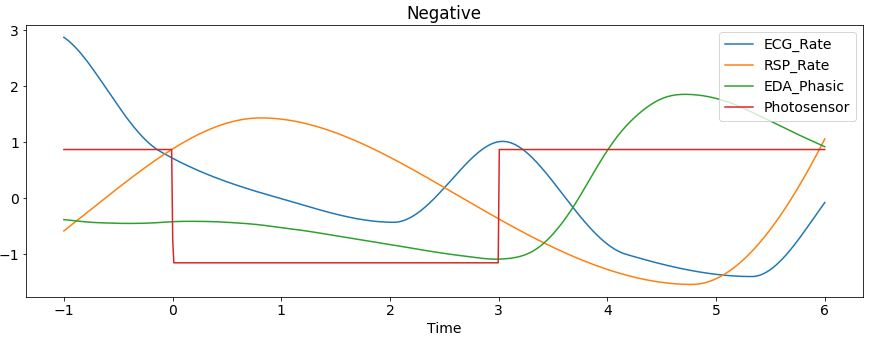

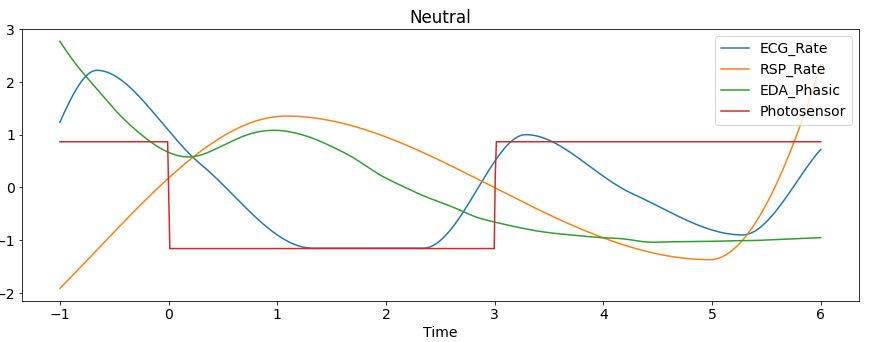

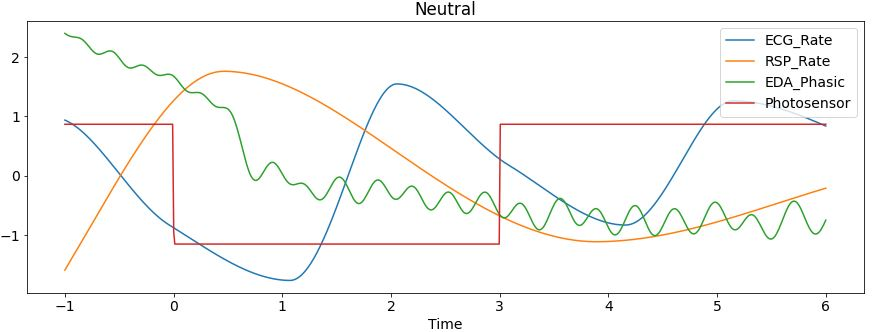

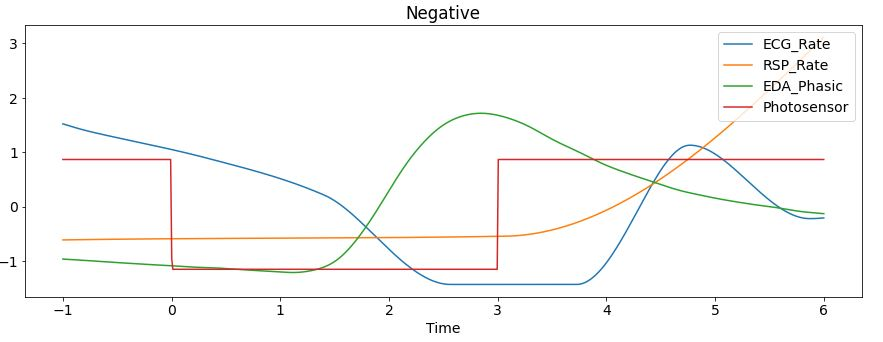

# Manually Extract Event Related Features
With these segments, we are able to compare how the physiological signals vary across the different events. We do this by:

Iterating through our object epochs

Storing the mean value of $X$ feature of each condition in a new dictionary

Saving the results in a readable format

We will call these 3 objects epochs-dictionary, the mean-dictionary and our results-dataframe.

In [26]:
df = {}  # Initialize an empty dict to store the results
         
# Iterate through epochs index and data
for epoch_index, epoch in epochs.items():
    df[epoch_index] = {}  # Initialize an empty dict inside of it
                            

    # Note: We will use the 100th value (corresponding to the event onset, 0s) as the baseline

    # ECG ====
    ecg_baseline = epoch["ECG_Rate"].values[100]  # Baseline
    ecg_mean = epoch["ECG_Rate"][0:4].mean()  # Mean heart rate in the 0-4 seconds
    # Store ECG in df
    df[epoch_index]["ECG_Rate_Mean"] = ecg_mean - ecg_baseline  # Correct for baseline

    # RSP ====
    rsp_baseline = epoch["RSP_Rate"].values[100]  # Baseline
    rsp_rate = epoch["RSP_Rate"][0:6].mean()  # Longer window for RSP that has a slower dynamic
    # Store RSP in df
    df[epoch_index]["RSP_Rate_Mean"] = rsp_rate - rsp_baseline  # Correct for baseline

    
    # EDA/SCR ====
    scr_max = epoch["SCR_Amplitude"][0:6].max()  # Maximum SCR peak
    # If no SCR, consider the magnitude, i.e. that the value is 0
    if np.isnan(scr_max):
        scr_max = 0  
    # Store SCR in df
    df[epoch_index]["SCR_Magnitude"] = scr_max



In [27]:
df = pd.DataFrame.from_dict(df, orient="index")  # Convert to a dataframe
df["Condition"] = condition_list  # Add the conditions
df  # Print DataFrame

,ECG_Rate_Mean,RSP_Rate_Mean,SCR_Magnitude,Condition
1,-2.005527,-0.591449,3.114808,Negative
2,-3.119900,-0.009901,0.000000,Neutral
3,1.336250,-0.899208,0.000000,Neutral
4,-3.543494,0.646818,1.675922,Negative


You can save this dataframe (df.to_csv("results.csv")) and proceed to do some actual statistics on it.

# Automatic Feature Extraction
While manual feature creation allows you to compute and extract exactly what you need, using our automated pipeline is a lot easier.

In [28]:
df = nk.bio_analyze(epochs, sampling_rate=100)
df

,Label,Condition,Event_Onset,ECG_Rate_Baseline,ECG_Rate_Max,ECG_Rate_Min,ECG_Rate_Mean,ECG_Rate_SD,ECG_Rate_Max_Time,ECG_Rate_Min_Time,...,RSP_Phase,RSP_Phase_Completion,EDA_Peak_Amplitude,EDA_SCR,SCR_Peak_Amplitude,SCR_Peak_Amplitude_Time,SCR_RiseTime,SCR_RecoveryTime,RSA_P2T,RSA_Gates
1,1,Negative,1024,58.962843,1.037157,-7.238706,-3.416404,2.462046,3.035765,5.329041,...,0.0,0.641256,1.995617,1,3.114808,4.718169,1.74,NaN,-0.031061,0.000000
2,2,Neutral,4957,64.000846,-0.056683,-5.177317,-3.209327,1.661333,0.011445,1.323319,...,0.0,0.462312,0.868942,0,NaN,NaN,NaN,NaN,-0.030944,-0.083058
3,3,Neutral,9224,55.976284,5.248206,-1.922230,1.891089,2.279224,2.054363,1.072961,...,0.0,0.752747,0.026651,0,NaN,NaN,NaN,NaN,-0.024188,0.132993
4,4,Negative,12984,57.505912,0.186396,-5.781774,-2.941543,2.142268,4.768240,2.565093,...,1.0,0.746667,1.056855,1,1.675922,2.845494,1.73,477.0,-0.020054,0.213656


# Plot Event-Related Features
You can now plot and compare how these features differ according to the event of interest.

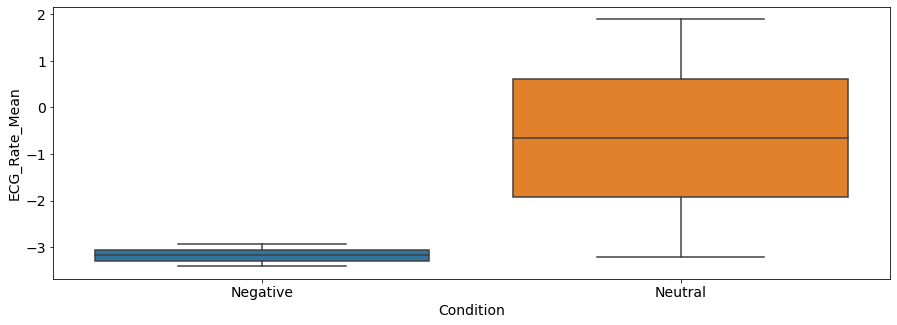

In [29]:
sns.boxplot(x="Condition", y="ECG_Rate_Mean", data=df);


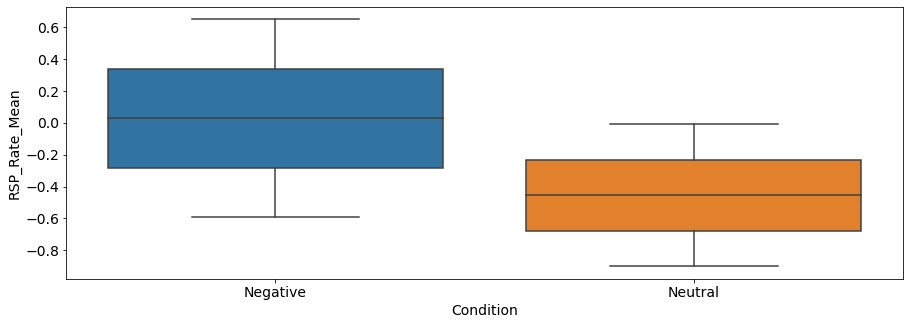

In [30]:
sns.boxplot(x="Condition", y="RSP_Rate_Mean", data=df);

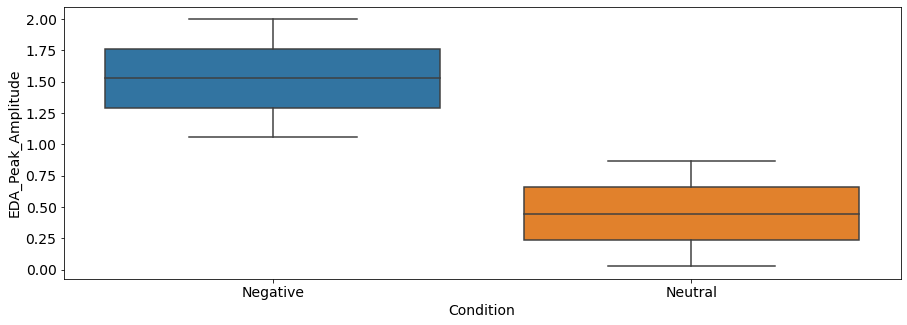

In [31]:
sns.boxplot(x="Condition", y="EDA_Peak_Amplitude", data=df);


 Interpretation: As we can see, there seems to be a difference between the negative and the neutral pictures. Negative stimuli, as compared to neutral stimuli, were related to a stronger cardiac deceleration (i.e., higher heart rate variability), an accelerated breathing rate, and higher SCR magnitude.

Of course, because of data size limits on Github, we had to downsample the signals and have only one participant with a few events. That said, the same workflow can apply for more events, and more participants (you just need to additionally loop through all participants).

jupyter nbconvert Event-related_Analysis.ipynb --to slides --post serve